# <a id='toc1_'></a>[Projet 3 - Préparez des données pour un organisme de santé publique](#toc0_)

**Table of contents**<a id='toc0_'></a>    
- [Projet 3 - Préparez des données pour un organisme de santé publique](#toc1_)    
  - [Contexte projet & Objectifs](#toc1_1_)    
    - [Installation & Imports des librairies](#toc1_1_1_)    
  - [Creations des fonctions utilitaires](#toc1_2_)    
    - [Valeurs manquantes, inutilles ou dupliqué](#toc1_2_1_)    
    - [Valeurs aberantes](#toc1_2_2_)    
    - [Fonctions de visualisations des graphiques](#toc1_2_3_)    
    - [Fonction generale pour gerer le rendu des graphiques](#toc1_2_4_)    
  - [Analyses & Manipulations des données](#toc1_3_)    
    - [Lecture du dataframe](#toc1_3_1_)    
    - [Etape 1 - Nettoyez et filtrez des features et produits](#toc1_3_2_)    
    - [Explication des variables restantes](#toc1_3_3_)    
      - [🍏 Valeurs nutritionnelles](#toc1_3_3_1_)    
      - [🏅 Scores et Étiquettes](#toc1_3_3_2_)    
    - [Etape 2 & 3 - Identifiez et traitez les valeurs aberrantes & Imputations de valeurs manquantes](#toc1_3_4_)    
      - [Methode 1 - Analyse métier](#toc1_3_4_1_)    
      - [Methode 2 - Analyse IQR](#toc1_3_4_2_)    
      - [Remplacement des valeurs aberantes](#toc1_3_5_)    
    - [Etape 4 - Analyse uni/bi  variée](#toc1_3_6_)    
      - [Pairplot](#toc1_3_6_1_)    
  - [Analyse en composante principale (PCA)](#toc1_4_)    
    - [Scree plot](#toc1_4_1_)    
    - [Cercle des correlation](#toc1_4_2_)    
    - [Interpretation des resultats](#toc1_4_3_)    
  - [ANOVA](#toc1_5_)    
    - [Calcul de l'anova](#toc1_5_1_)    
    - [Plot de l'anova](#toc1_5_2_)    
    - [Interpretation des resultats](#toc1_5_3_)    
  - [Respect des RGPD](#toc1_6_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_1_'></a>[Contexte projet & Objectifs](#toc0_)

Contexte :
L'objectif est d'améliorer la base de données Open Food Facts, qui recueille des informations sur les produits alimentaires du marché. Cette base de données est utilisée par un organisme de santé publique pour analyser les habitudes alimentaires de la population et prendre des décisions éclairées.


Problématique :
La base de données Open Food Facts présente des problèmes de qualité et de complétude des données. Il est nécessaire de nettoyer les données, de traiter les valeurs manquantes et aberrantes, et de réaliser des analyses pour évaluer la faisabilité du projet.

### <a id='toc1_1_1_'></a>[Installation & Imports des librairies](#toc0_)

In [247]:
# Installation des libs
# %pip install pandas numpy scikit-learn matplotlib seaborn
# %pip install skimpy
# %pip install missingno
# %pip install scipy
# %pip install feature-engine
# %pip install plotly
# %pip install mlxtend

In [248]:
# Import des librairies
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from skimpy import skim
import missingno as msno
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from mlxtend.plotting import plot_pca_correlation_graph
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

%matplotlib inline

## <a id='toc1_2_'></a>[Creations des fonctions utilitaires](#toc0_)

### <a id='toc1_2_1_'></a>[Valeurs manquantes, inutilles ou dupliqué](#toc0_)

In [249]:
def delete_useless_duplicate_and_missing_columns(data, useless_columns, threshold,):
    """Deletes columns with more than threshold% of missing values and generates a bar plot showing the remaining columns in the new dataframe.

    Args:
        data (pd.Dataframe): Any dataframe you want to process
        useless_columns(list): A list with all the columns you want to delete
        threshold (int): Threshold percentage of missing values above which columns are deleted

    Returns:
        data (pd.Dataframe):The dataframe with columns removed if they have more than threshold% missing values
    """
    # Calculer le pourcentage de valeurs manquantes pour chaque colonne
    missing_percent = data.isnull().mean() * 100

    # Filtrer les colonnes qui ont plus de threshold% de valeurs manquantes
    cols_with_many_missing = missing_percent[missing_percent > threshold].index
    print(f"Colonnes avec plus de {threshold}% de valeurs manquantes : {len(cols_with_many_missing)}")

    # Supression des colonnes
    data = data.drop(columns = [*cols_with_many_missing , *useless_columns])
    print(f"Colonnes restante apres traitement: {data.shape[1]}")

    # Supression des doublons
    data = data.drop_duplicates()
    return data

### <a id='toc1_2_2_'></a>[Valeurs aberantes](#toc0_)

In [250]:
def identify_and_replace_outliers(data):
    """Identify and replace outliers in the DataFrame.

    This function identifies outliers based on the IQR method and replaces them with NaN.
    It then imputes missing values using Iterative Imputer for the 'nutrition-score-fr_100g' column,
    and uses the median based on 'nutrition_grade_fr' for other columns.
    Finally, categorical data with missing values is imputed with the 'Unknown' value.

    Args:
        data (pd.DataFrame): The DataFrame to process.

    Returns:
        pd.DataFrame: The DataFrame with outliers replaced and missing values imputed.
    """
    
    # Step 1: Get numerical columns
    numerical_columns = data.select_dtypes(include="number").columns.tolist()

    # Step 2: Calculate the percentage of missing values per column
    missing_percentage = data[numerical_columns].isnull().mean()

    # Step 3: Identify columns to impute with KNN (Iterative Imputer) and columns to impute with median
    columns_imputer = ['nutrition-score-fr_100g']  # Only the 'nutrition-score-fr_100g' column will use Iterative Imputer
    columns_median = [col for col in numerical_columns if col != 'nutrition-score-fr_100g']

    # Step 4: Initialize Iterative Imputer for the 'nutrition-score-fr_100g' column
    imputer = IterativeImputer(max_iter=10, random_state=0)

    # Impute the 'nutrition-score-fr_100g' column
    if columns_imputer:
        data[columns_imputer] = imputer.fit_transform(data[columns_imputer])

    # Step 5: Replace missing values in other numerical columns with the median based on 'nutrition_grade_fr'
    if columns_median:
        for col in columns_median:
            data[col] = data.groupby('nutrition_grade_fr')[col].transform(lambda x: x.fillna(x.median()))

    # Step 6: Replace missing values in categorical columns with 'Unknown'
    categorical_columns = data.select_dtypes(include="object").columns.tolist()
    if categorical_columns:
        data[categorical_columns] = data[categorical_columns].fillna("Unknown")

    # Step 7: Replace values < 0 or > 100 with NaN (if outside the reasonable range)
    data[numerical_columns] = data[numerical_columns].apply(lambda x: x.where((x >= 0) & (x <= 100), np.nan))

    # Step 8: Calculate the quartiles and IQR
    Q1 = data[numerical_columns].quantile(0.25)
    Q3 = data[numerical_columns].quantile(0.75)
    IQR = Q3 - Q1

    # Step 9: Define bounds for outliers and replace them with NaN
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Check for any values outside the IQR and replace them with NaN
    for col in numerical_columns:
        data[col] = data[col].apply(lambda x: np.nan if x < lower_bound[col] or x > upper_bound[col] else x)

    return data


### <a id='toc1_2_3_'></a>[Fonctions de visualisations des graphiques](#toc0_)

In [251]:

def render_boxplot(data, title, log_scale=False):
    """Render a box plot of the given DataFrame.

    Args:
        data (pd.DataFrame): The data to visualize, with numerical columns.
        title (str): The title of the plot.
        log_scale (bool, optional): If True, use logarithmic scale for y-axis. Defaults to False.
    
    Returns:
        plt.Axes: The Axes object containing the plot.
    """
    
    # Recuperer les variables numeriques
    numerical_columns = data.select_dtypes(include='number').columns
    
    # Cree le plot
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=data[numerical_columns])

    if not title:
        title = ''
    plt.title(title)
    
    # Set y-axis en echelle log si True
    if log_scale:
        plt.yscale('log')

    plt.tick_params(axis='x', rotation=90)
    plt.tight_layout()
    plt.show()
    
def render_missing_values_by_nutriscore_and_pnns(data, pnns_column='pnns_groups_1', nutriscore_column='nutrition_grade_fr', title='Pourcentage de valeurs manquantes par Nutri-Score et groupe PNNS'):
    """
    Trace un barplot montrant le pourcentage de valeurs manquantes pour chaque grade de Nutri-Score, par groupe PNNS.

    Args:
        data (pd.DataFrame): Le DataFrame contenant les données, incluant les colonnes Nutri-Score et PNNS.
        pnns_column (str): Nom de la colonne de groupe PNNS (ex : 'pnns_groups_1'). Par défaut 'pnns_groups_1'.
        nutriscore_column (str): Nom de la colonne Nutri-Score (ex : 'nutrition_grade_fr'). Par défaut 'nutrition_grade_fr'.
        title (str): Le titre du graphique. Par défaut 'Pourcentage de valeurs manquantes par Nutri-Score et groupe PNNS'.

    Returns:
        plt.Axes: L'objet Axes contenant le graphique.
    """
    # Calculer le pourcentage de valeurs manquantes par grade de Nutri-Score et groupe PNNS
    missing_data = data.groupby([pnns_column, nutriscore_column]).apply(lambda x: x.isnull().mean() * 100)

    # Moyenne des pourcentages de valeurs manquantes pour chaque groupe Nutri-Score et PNNS
    missing_data_mean = missing_data.mean(axis=1).unstack().fillna(0)  # Organiser les données pour un barplot groupé

    # Tracer le barplot groupé
    plt.figure(figsize=(14, 8))
    missing_data_mean.plot(kind='bar', stacked=False, colormap='viridis', width=0.8)

    # Ajouter des labels et le titre
    plt.title(title)
    plt.xlabel("Groupes PNNS")
    plt.ylabel("Pourcentage de valeurs manquantes (%)")
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Nutri-Score')
    plt.tight_layout()
    plt.show()

def render_missing_values_barplot_by_pnns(data, column='pnns_groups_1', title='Pourcentage de valeurs manquantes par groupe PNNS'):
    """
    Trace un barplot montrant le pourcentage de valeurs manquantes pour chaque groupe dans la colonne `pnns_groups_1`.

    Args:
        data (pd.DataFrame): Le DataFrame contenant les données, incluant une colonne `pnns_groups_1` ou similaire.
        pnns_column (str): Nom de la colonne de groupe PNNS. Par défaut 'pnns_groups_1'.
        title (str): Le titre du graphique. Par défaut 'Pourcentage de valeurs manquantes par groupe PNNS'.

    Returns:
        plt.Axes: L'objet Axes contenant le graphique.
    """
    # Calculer le pourcentage de valeurs manquantes par groupe PNNS
    missing_data = data.groupby(column).apply(lambda x: x.isnull().mean() * 100)
    
    # Calculer la moyenne des pourcentages de valeurs manquantes pour chaque groupe
    missing_data_mean = missing_data.mean(axis=1).sort_values(ascending=False)
    
    # Tracer le barplot
    plt.figure(figsize=(12, 6))
    sns.barplot(x=missing_data_mean.index, y=missing_data_mean.values, palette="viridis")
    
    # Ajouter des labels et le titre
    plt.title(title)
    plt.xlabel("Groupes PNNS")
    # plt.ylabel("Pourcentage de valeurs manquantes (%)")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

def render_heatmap_missing_value(data, title):
    if not title:
        title = 'Heatmap des valeurs manquantes'
        # Faire une Heatmap des valeurs manquantes
        plt.figure(figsize=(12, 8))
        sns.heatmap(data.sample(10_000).isnull(), cmap='plasma', cbar=False, yticklabels=False)
        plt.title(title, fontsize=16)
        plt.show()


def render_correlation_matrix(data, title):
    if not title:
        title = 'Matrice de correlation'
        # Lister les colonnes numerique
        numerical_columns = list(data.select_dtypes(include="number").columns)
        some_array = data[numerical_columns].corr()
        sns.heatmap(some_array, cmap='viridis', annot=True, fmt=".1f")
        plt.title(title, fontsize=16)
        plt.show()

def render_piechart(data, col, title):
    pie_chart_values = data[col].value_counts()
    sns.set_style("whitegrid")
    plt.figure(figsize=(6,6))
    plt.pie(pie_chart_values, labels=pie_chart_values.index, autopct='%1.1f%%')
    plt.title(title)
    plt.show()

def render_pca(data, cols, dimensions):
    data_clean = data[cols].dropna()  # or apply imputation techniques
    figure, correlation_matrix = plot_pca_correlation_graph(data_clean,                                                         
                                                        cols,
                                                        dimensions=dimensions,
                                                        figure_axis_size=10)
def render_anova(df, x, y, title):
    # Étape 3 : Tracer le boxplot
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df, x=x, y=y)

    # Ajouter des titres et labels
    plt.title(title)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.legend()
    plt.grid(True)
    plt.show()

### <a id='toc1_2_4_'></a>[Fonction generale pour gerer le rendu des graphiques](#toc0_)

In [252]:
def generate_graph(data, graph_type ,title=None, log_scale=False, col='nutrition_grade_fr', cols=[], dimensions=(1,2), x='nutrition_grade_fr',  y='energy_100g' ):

    # boxplot
    if graph_type == 'boxplot':
        render_boxplot(data, title, log_scale)

    # Heatmap des valeurs manquantes
    if graph_type == 'heatmap':
        render_heatmap_missing_value(data, title)
    
    # Barchart des valeurs manquantes
    if graph_type == 'msno bar':
        msno.bar(data, log=log_scale)

    # Correlation matix
    if graph_type == 'corr':
        render_correlation_matrix(data, title)
    
    if graph_type == 'pie':
        render_piechart(data, col, title)
    
    if graph_type == 'pca':
        render_pca(data, cols, dimensions)
    
    if graph_type == 'anova':
        render_anova(data, x, y, title)
    
    if graph_type == 'barplot pnns':
        render_missing_values_barplot_by_pnns(data, col)
        
    if graph_type == 'pnns/nutriscore':
        render_missing_values_by_nutriscore_and_pnns(data, pnns_column=col)
        

## <a id='toc1_3_'></a>[Analyses & Manipulations des données](#toc0_)

### <a id='toc1_3_1_'></a>[Lecture du dataframe](#toc0_)

In [253]:
# Lecture du dataframe
df_origin = pd.read_csv('openfoodfacts_dataset.csv', sep='\t')

# Faire une copie du dataframe pour garder le dataframe original intact de toute modification
df = df_origin.copy()
df.describe()

C:\Users\223115316\AppData\Local\Temp\ipykernel_28008\1038874156.py:2: DtypeWarning: Columns (0,3,5,19,20,24,25,26,27,28,35,36,37,38,39,48) have mixed types. Specify dtype option on import or set low_memory=False.
  df_origin = pd.read_csv('openfoodfacts_dataset.csv', sep='\t')


,no_nutriments,additives_n,ingredients_from_palm_oil_n,ingredients_from_palm_oil,ingredients_that_may_be_from_palm_oil_n,ingredients_that_may_be_from_palm_oil,nutrition_grade_uk,energy_100g,energy-from-fat_100g,fat_100g,...,ph_100g,fruits-vegetables-nuts_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
count,0.0,248939.000000,248939.000000,0.0,248939.000000,0.0,0.0,2.611130e+05,857.000000,243891.000000,...,49.000000,3036.000000,165.000000,948.000000,0.0,268.000000,221210.000000,221210.000000,0.0,0.0
mean,NaN,1.936024,0.019659,NaN,0.055246,NaN,NaN,1.141915e+03,585.501214,12.730379,...,6.425698,31.458587,15.412121,49.547785,NaN,341.700764,9.165535,9.058049,NaN,NaN
std,NaN,2.502019,0.140524,NaN,0.269207,NaN,NaN,6.447154e+03,712.809943,17.578747,...,2.047841,31.967918,3.753028,18.757932,NaN,425.211439,9.055903,9.183589,NaN,NaN
min,NaN,0.000000,0.000000,NaN,0.000000,NaN,NaN,0.000000e+00,0.000000,0.000000,...,0.000000,0.000000,8.000000,6.000000,NaN,0.000000,-15.000000,-15.000000,NaN,NaN
25%,NaN,0.000000,0.000000,NaN,0.000000,NaN,NaN,3.770000e+02,49.400000,0.000000,...,6.300000,0.000000,12.000000,32.000000,NaN,98.750000,1.000000,1.000000,NaN,NaN
50%,NaN,1.000000,0.000000,NaN,0.000000,NaN,NaN,1.100000e+03,300.000000,5.000000,...,7.200000,23.000000,15.000000,50.000000,NaN,195.750000,10.000000,9.000000,NaN,NaN
75%,NaN,3.000000,0.000000,NaN,0.000000,NaN,NaN,1.674000e+03,898.000000,20.000000,...,7.400000,51.000000,15.000000,64.250000,NaN,383.200000,16.000000,16.000000,NaN,NaN
max,NaN,31.000000,2.000000,NaN,6.000000,NaN,NaN,3.251373e+06,3830.000000,714.290000,...,8.400000,100.000000,25.000000,100.000000,NaN,2842.000000,40.000000,40.000000,NaN,NaN


Verifions si les données indiqué par le .describe sont coherante en nous basant sur les données du site openfactfood

| **Colonne**                           | **Moyenne Observée** | **Unité**      | **Valeur Moyenne Tolérée** | **Valeur Minimale** | **Valeur Maximale** |
|---------------------------------------|----------------------|----------------|----------------------------|----------------------|----------------------|
| energy_100g                           | 1141,92              | kJ             | 800 à 2500                 | 0                    | 5000+               |
| energy_100g                           | 272,92               | kcal           | 200 à 600                  | 0                    | 3500+               |
| fat_100g                              | 12,73                | g              | 0 à 20                     | 0                    | 100                  |
| saturated-fat_100g                    | 5,13                 | g              | 0 à 10                     | 0                    | 50                   |
| carbohydrates_100g                    | 32,07                | g              | 10 à 60                    | 0                    | 90                   |
| sugars_100g                           | 16,00                | g              | 0 à 30                     | 0                    | 80                   |
| fiber_100g                            | 2,86                 | g              | 2 à 10                     | 0                    | 40                   |
| proteins_100g                         | 7,08                 | g              | 5 à 25                     | 0                    | 60                   |
| salt_100g                             | 2,03                 | g              | 0 à 5                      | 0                    | 15                   |
| sodium_100g                           | 0,80                 | g              | 0 à 2                      | 0                    | 5                    |
| nutrition-score-fr_100g               | 9,17                 | score          | -15 à 40                   | -15                  | 100                  |
| nutrition-score-uk_100g               | 9,06                 | score          | -15 à 40                   | -15                  | 100                  |

toutes les information on été trouvez [ici](https://wiki.openfoodfacts.org/Main_Page)


On peut deja voir plusieurs choses notamment les valeurs qui sont negative ou superieur a 100g pour 100g qui sont impossible dans notre contexte et en ce basant sur le tableau ci dessus, de plus on constate qu'il y a beaucoupe de valeurs manquantes pour mieux s'en rendre compte nous allons les visualisé grace a la heatmap des valeurs manquantes

### <a id='toc1_3_2_'></a>[Etape 1 - Nettoyez et filtrez des features et produits](#toc0_)

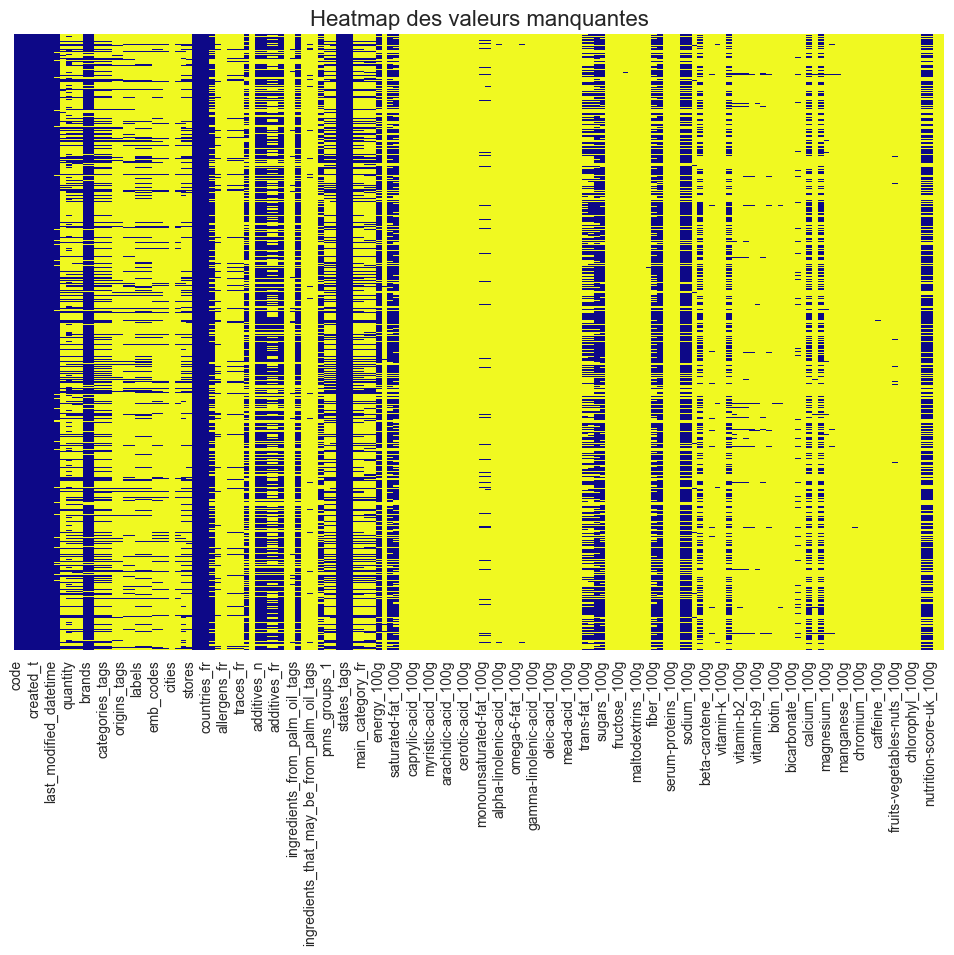

In [254]:
# Affichages des valeurs manquantes
generate_graph(df, 'heatmap')

In [255]:
useless_columns = [
                    'code', 
                    'url', 
                    'creator', 
                    'created_t', 
                    'created_datetime',
                    'last_modified_t', 
                    'last_modified_datetime', 
                    'quantity',
                    'nutrition-score-uk_100g',
                    'countries',
                    'countries_tags',
                    'countries_fr',
                    'ingredients_text',
                    'serving_size',
                    'brands',
                    'brands_tags',
                    'states',
                    'states_fr',
                    'states_tags',
                    'ingredients_from_palm_oil_n',
                    'ingredients_that_may_be_from_palm_oil_n',
                    'additives',
                    'sodium_100g',
                    'fat_100g',                          
                    ]

# Supression des colonnes inutiles, doubles ou avec trop de valeurs manquantes
df = delete_useless_duplicate_and_missing_columns(data=df, useless_columns=useless_columns, threshold=50)

Colonnes avec plus de 50% de valeurs manquantes : 128
Colonnes restante apres traitement: 11


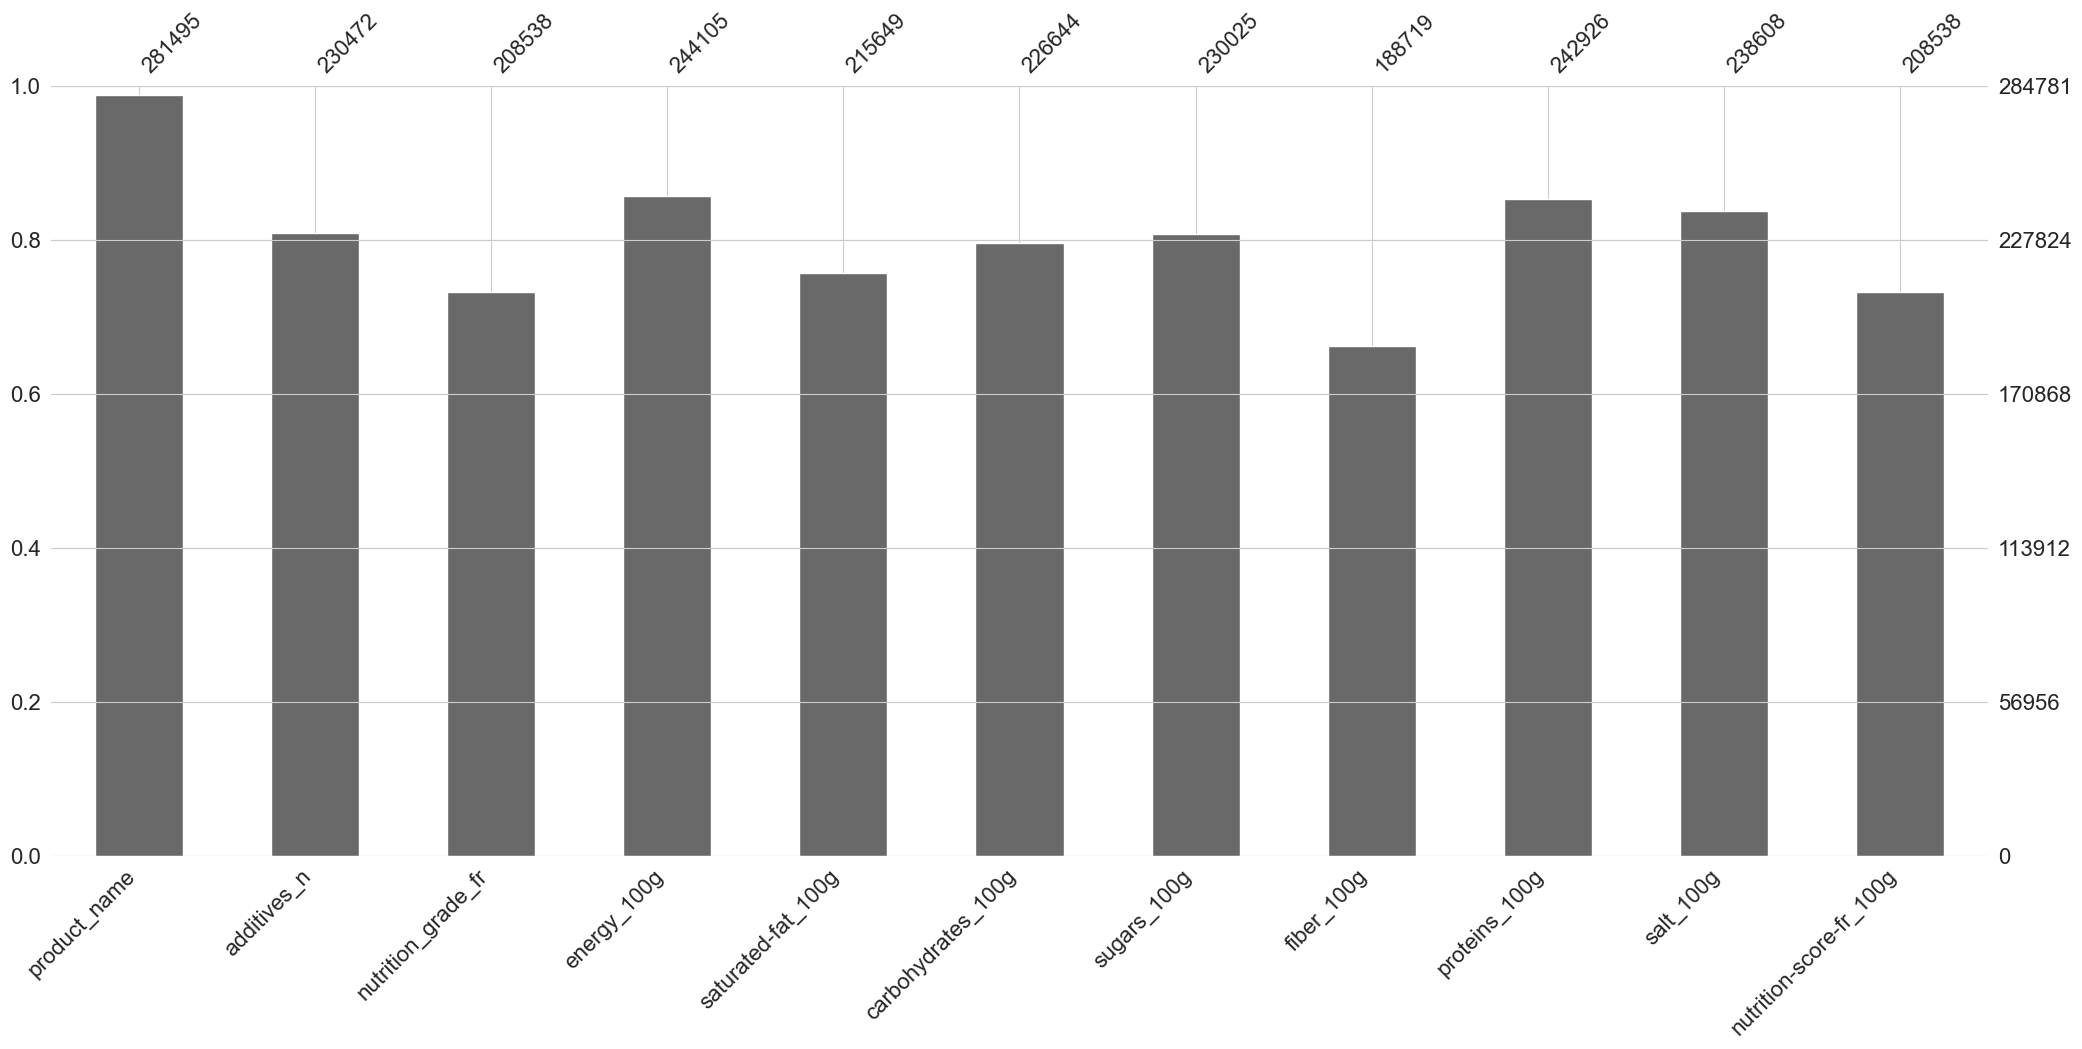

In [256]:
# Affichage des valeurs manquantes après suppessions des colonnes vide
generate_graph(df, 'msno bar')

### <a id='toc1_3_3_'></a>[Explication des variables restantes](#toc0_)

#### <a id='toc1_3_3_1_'></a>[🍏 Valeurs nutritionnelles](#toc0_)
| Variable               | Description                                                                                          |
|------------------------|------------------------------------------------------------------------------------------------------|
| **energy_100g**        | L'énergie (en kilojoules)                                       |
| **fat_100g**           | La quantité de graisses (en grammes)                           |
| **saturated-fat_100g** | La quantité de graisses saturées (en grammes)                  |
| **carbohydrates_100g** | La quantité de glucides (en grammes)                           |
| **sugars_100g**        | La quantité de sucres (en grammes)                             |
| **fiber_100g**         | La quantité de fibres alimentaires (en grammes)                |
| **proteins_100g**      | La quantité de protéines (en grammes)                          |
| **salt_100g**          | La quantité de sel (en grammes)                                |
| **sodium_100g**        | La quantité de sodium (en grammes)                             |
| **energy_kcal**        | L'énergie (en kilocalories)                                    |


#### <a id='toc1_3_3_2_'></a>[🏅 Scores et Étiquettes](#toc0_)
| Variable               | Description                                                                                          |
|------------------------|------------------------------------------------------------------------------------------------------|
| **nutrition_grade_fr** | La note nutritionnelle du produit, souvent exprimée sous forme de lettre, en français.               |
| **nutrition-score-fr_100g** | Le score nutritionnel du produit pour le marché français, basé sur des critères de santé.           |


### <a id='toc1_3_4_'></a>[Etape 2 & 3 - Identifiez et traitez les valeurs aberrantes & Imputations de valeurs manquantes](#toc0_)

#### <a id='toc1_3_4_1_'></a>[Methode 1 - Analyse métier](#toc0_)
L'analyse métier, segmentée par les groupes de produits pnns est essentielle pour prendre en compte les spécificités propres à chaque catégorie alimentaire. En appliquant l'analyse par catégorie, on évite de classer certaines valeurs typiques comme aberrantes, offrant ainsi une meilleure compréhension des données en respectant les caractéristiques inhérentes à chaque groupe de produits. Voyons donc la distribution du pnns group en fonction du Nutri-Score et des valeurs manquantes associé

C:\Users\223115316\AppData\Local\Temp\ipykernel_28008\637962776.py:77: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  missing_data = data.groupby(column).apply(lambda x: x.isnull().mean() * 100)
C:\Users\223115316\AppData\Local\Temp\ipykernel_28008\637962776.py:84: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=missing_data_mean.index, y=missing_data_mean.values, palette="viridis")


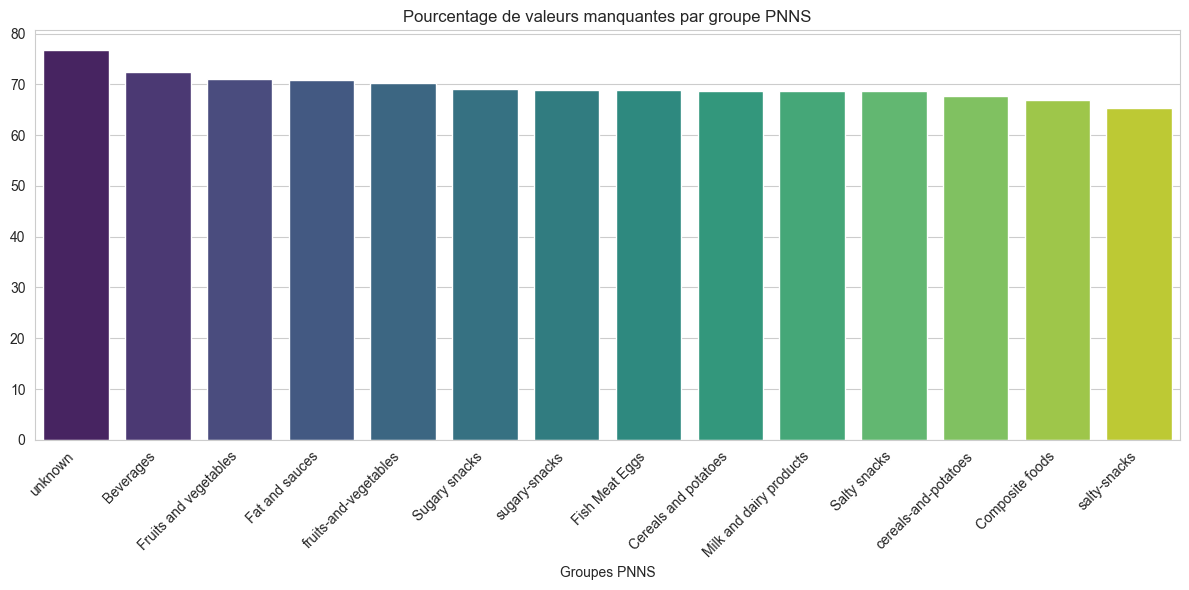

In [257]:
# Afficher le pourcentage manquant par categorie de produit
render_missing_values_barplot_by_pnns(df_origin, column='pnns_groups_1')

C:\Users\223115316\AppData\Local\Temp\ipykernel_28008\637962776.py:46: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  missing_data = data.groupby([pnns_column, nutriscore_column]).apply(lambda x: x.isnull().mean() * 100)


<Figure size 1400x800 with 0 Axes>

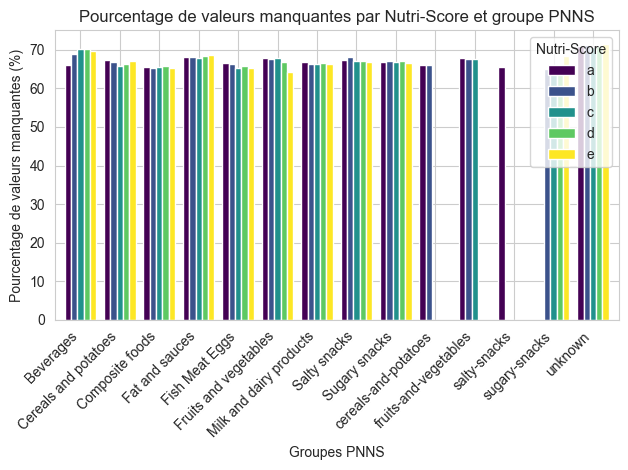

In [258]:
# Afficher le nutriscore par pnns group et par nutriscore et par remplissage
render_missing_values_by_nutriscore_and_pnns(df_origin, 'pnns_groups_1')

Je ne pense pas qu'utiliser l’approche métier par les groupes de produits (pnns_groups_1 et pnns_groups_2) pour la détection des valeurs aberrantes soit judicieux, car les colonnes présentent plus de 80 % de valeurs manquantes.

Avec un tel niveau de missing values, le regroupement des produits par catégorie aurait **introduit un biais significatif et limité la pertinence de l’analyse**

En effet, sans suffisamment de données pour identifier les caractéristiques propres à chaque catégorie, l’approche métier aurait été partielle et imprécise. Pour garantir la fiabilité de l’analyse des valeurs aberrantes, j’ai donc privilégié une approche statistique et métier fondés sur l’IQR et le Nutri-Score grade, plus robuste face aux données manquantes dans les colonnes de catégori

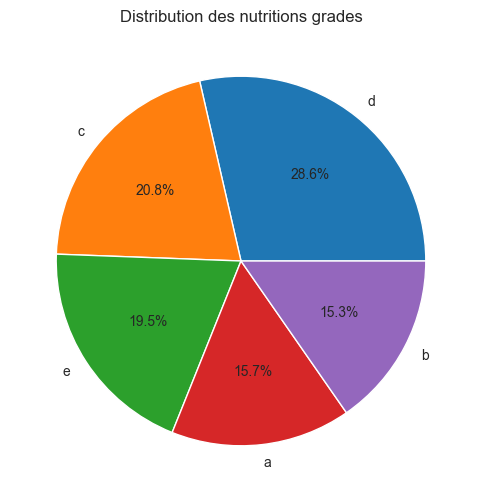

In [259]:
# pie chart du nutrition grade
generate_graph(data=df, graph_type='pie' ,col='nutrition_grade_fr', title='Distribution des nutritions grades')

#### <a id='toc1_3_4_2_'></a>[Methode 2 - Analyse IQR](#toc0_)

L'analyse IQR permet de détecter de manière systématique les valeurs extrêmes dans les données quantitatives. En identifiant les valeurs situées en dehors de l’intervalle interquartile, cette méthode aide à éliminer les valeurs aberrantes purement statistiques qui pourraient fausser l’analyse des données. On pense au préalable a vérifier les valeurs atypiques pour être sur de la fiabilité de l'analyse.

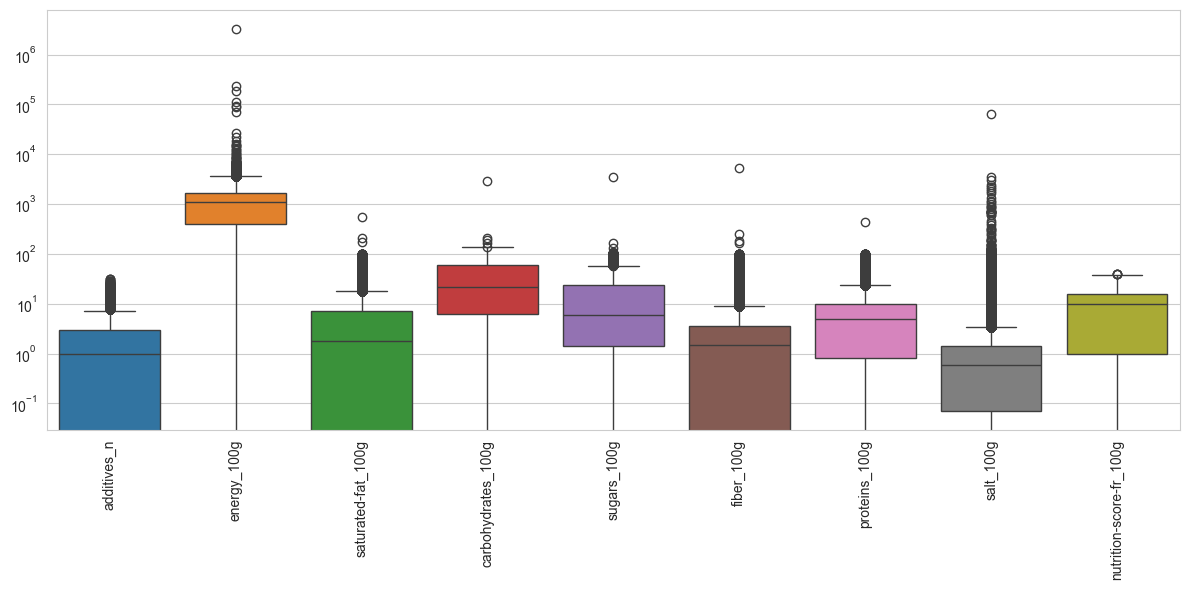

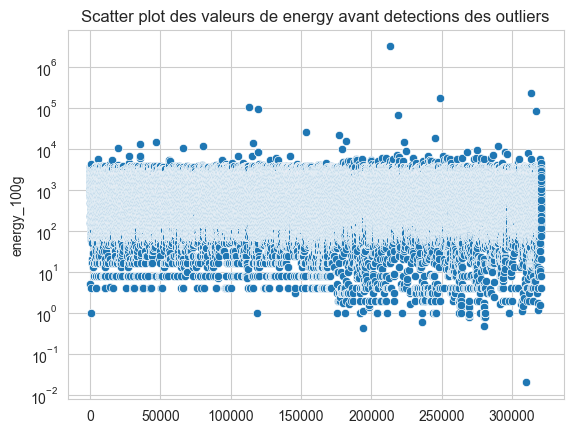

In [260]:
# Identification des valeurs aberrantes (multi variée)
generate_graph(data=df, graph_type='boxplot' ,log_scale=True)

# Scatter PLot de la colonne energy (uni variée)
sns.scatterplot(data=df['energy_100g'])
plt.title('Scatter plot des valeurs de energy avant detections des outliers')
plt.yscale('log')

#### <a id='toc1_3_5_'></a>[Remplacement des valeurs aberantes](#toc0_)

Afin de savoir quelle méthode utilisé pour le remplacement, je commence par faire la matrice de corrélation pour voir les colonnes corréler ensemble

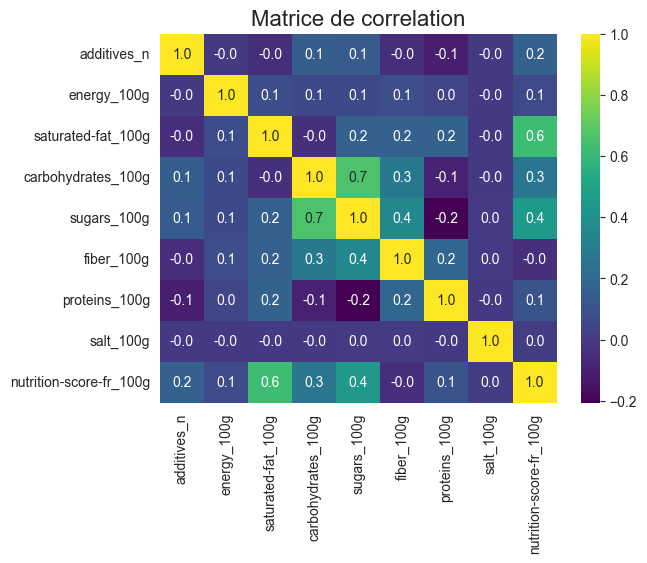

In [261]:
# Matrice de correlations
generate_graph(data=df, graph_type='corr')

Nous pouvons voir qu'il y a de forte corellation entre le nutriscore et les valeurs nutritionnel nous allons donc utiliser iterative imputer pour la colonne nutrition score et utiliser le remplacement par la medianne en fonction du nutriscore pour les autre colonnes, quant au donnée categorielle un remplacement par 'unknow' semble etre la meilleur methode afin de ne pas introduire de bias dans le dataset, pour ce qui est des valeurs atypique et aberante j'ai dabord supprimer les valeurs superieur a 100g et inferieur a 0g car impossible en realité puis j'ai utiliser l'iqr pour identifié les valeurs aberantes restante, nous n'oublieront pas de verifié la coherance par rapport au données du tableau ci-dessus avec les valeurs min et max pour chaque valeurs nutritionnel

In [262]:
# Identification et remplacerment des outliers
df = identify_and_replace_outliers(data=df)
df.describe()

,additives_n,energy_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,nutrition-score-fr_100g
count,200822.000000,7694.000000,193399.000000,208527.000000,196994.000000,194442.000000,197743.000000,197157.000000,246276.000000
mean,1.617383,47.353213,3.462689,33.112048,11.874114,1.736438,6.534121,0.758673,10.516535
std,1.718740,37.144466,4.495576,27.361602,14.797242,2.011702,5.868348,0.755322,6.167716
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.425000,0.000000,8.300000,1.100000,0.000000,1.670000,0.100000,8.000000
50%,1.000000,59.000000,1.400000,24.680000,4.500000,1.100000,5.260000,0.584200,9.237415
75%,2.000000,79.425000,5.500000,57.100000,18.600000,2.900000,9.700000,1.206500,14.000000
max,7.000000,100.000000,17.840000,100.000000,56.360000,8.240000,23.720000,3.251200,25.000000


Après traitement des outliers et des valeurs manquantes, nous pouvons constater grâce au describe que les outlier ont bien été traiter tout en gardant les valeurs atypiques comme vu dans le tableau plus haut, il ne nous reste plus qu'à afficher le boxplot pour avoir un aperçu plus visuel

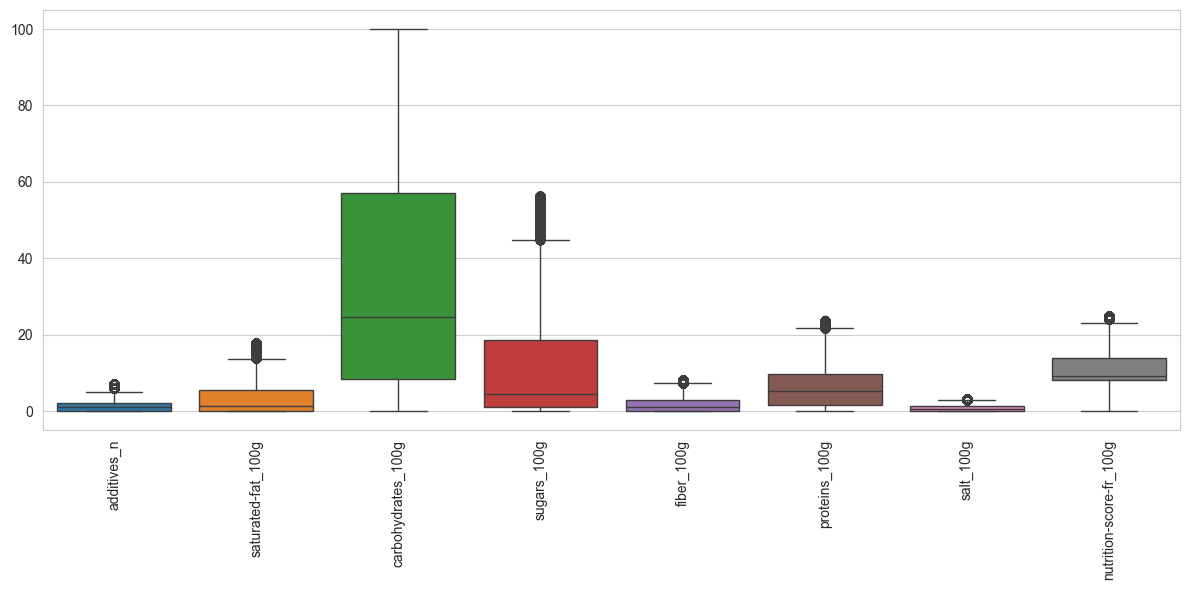

In [263]:
# Visualisations des colonnes après remplacements des valeurs manquantes
generate_graph(data=df.drop('energy_100g', axis=1), graph_type='boxplot' ,log_scale=False)

### <a id='toc1_3_6_'></a>[Etape 4 - Analyse multi  variée](#toc0_)

#### <a id='toc1_3_6_1_'></a>[Pairplot](#toc0_)

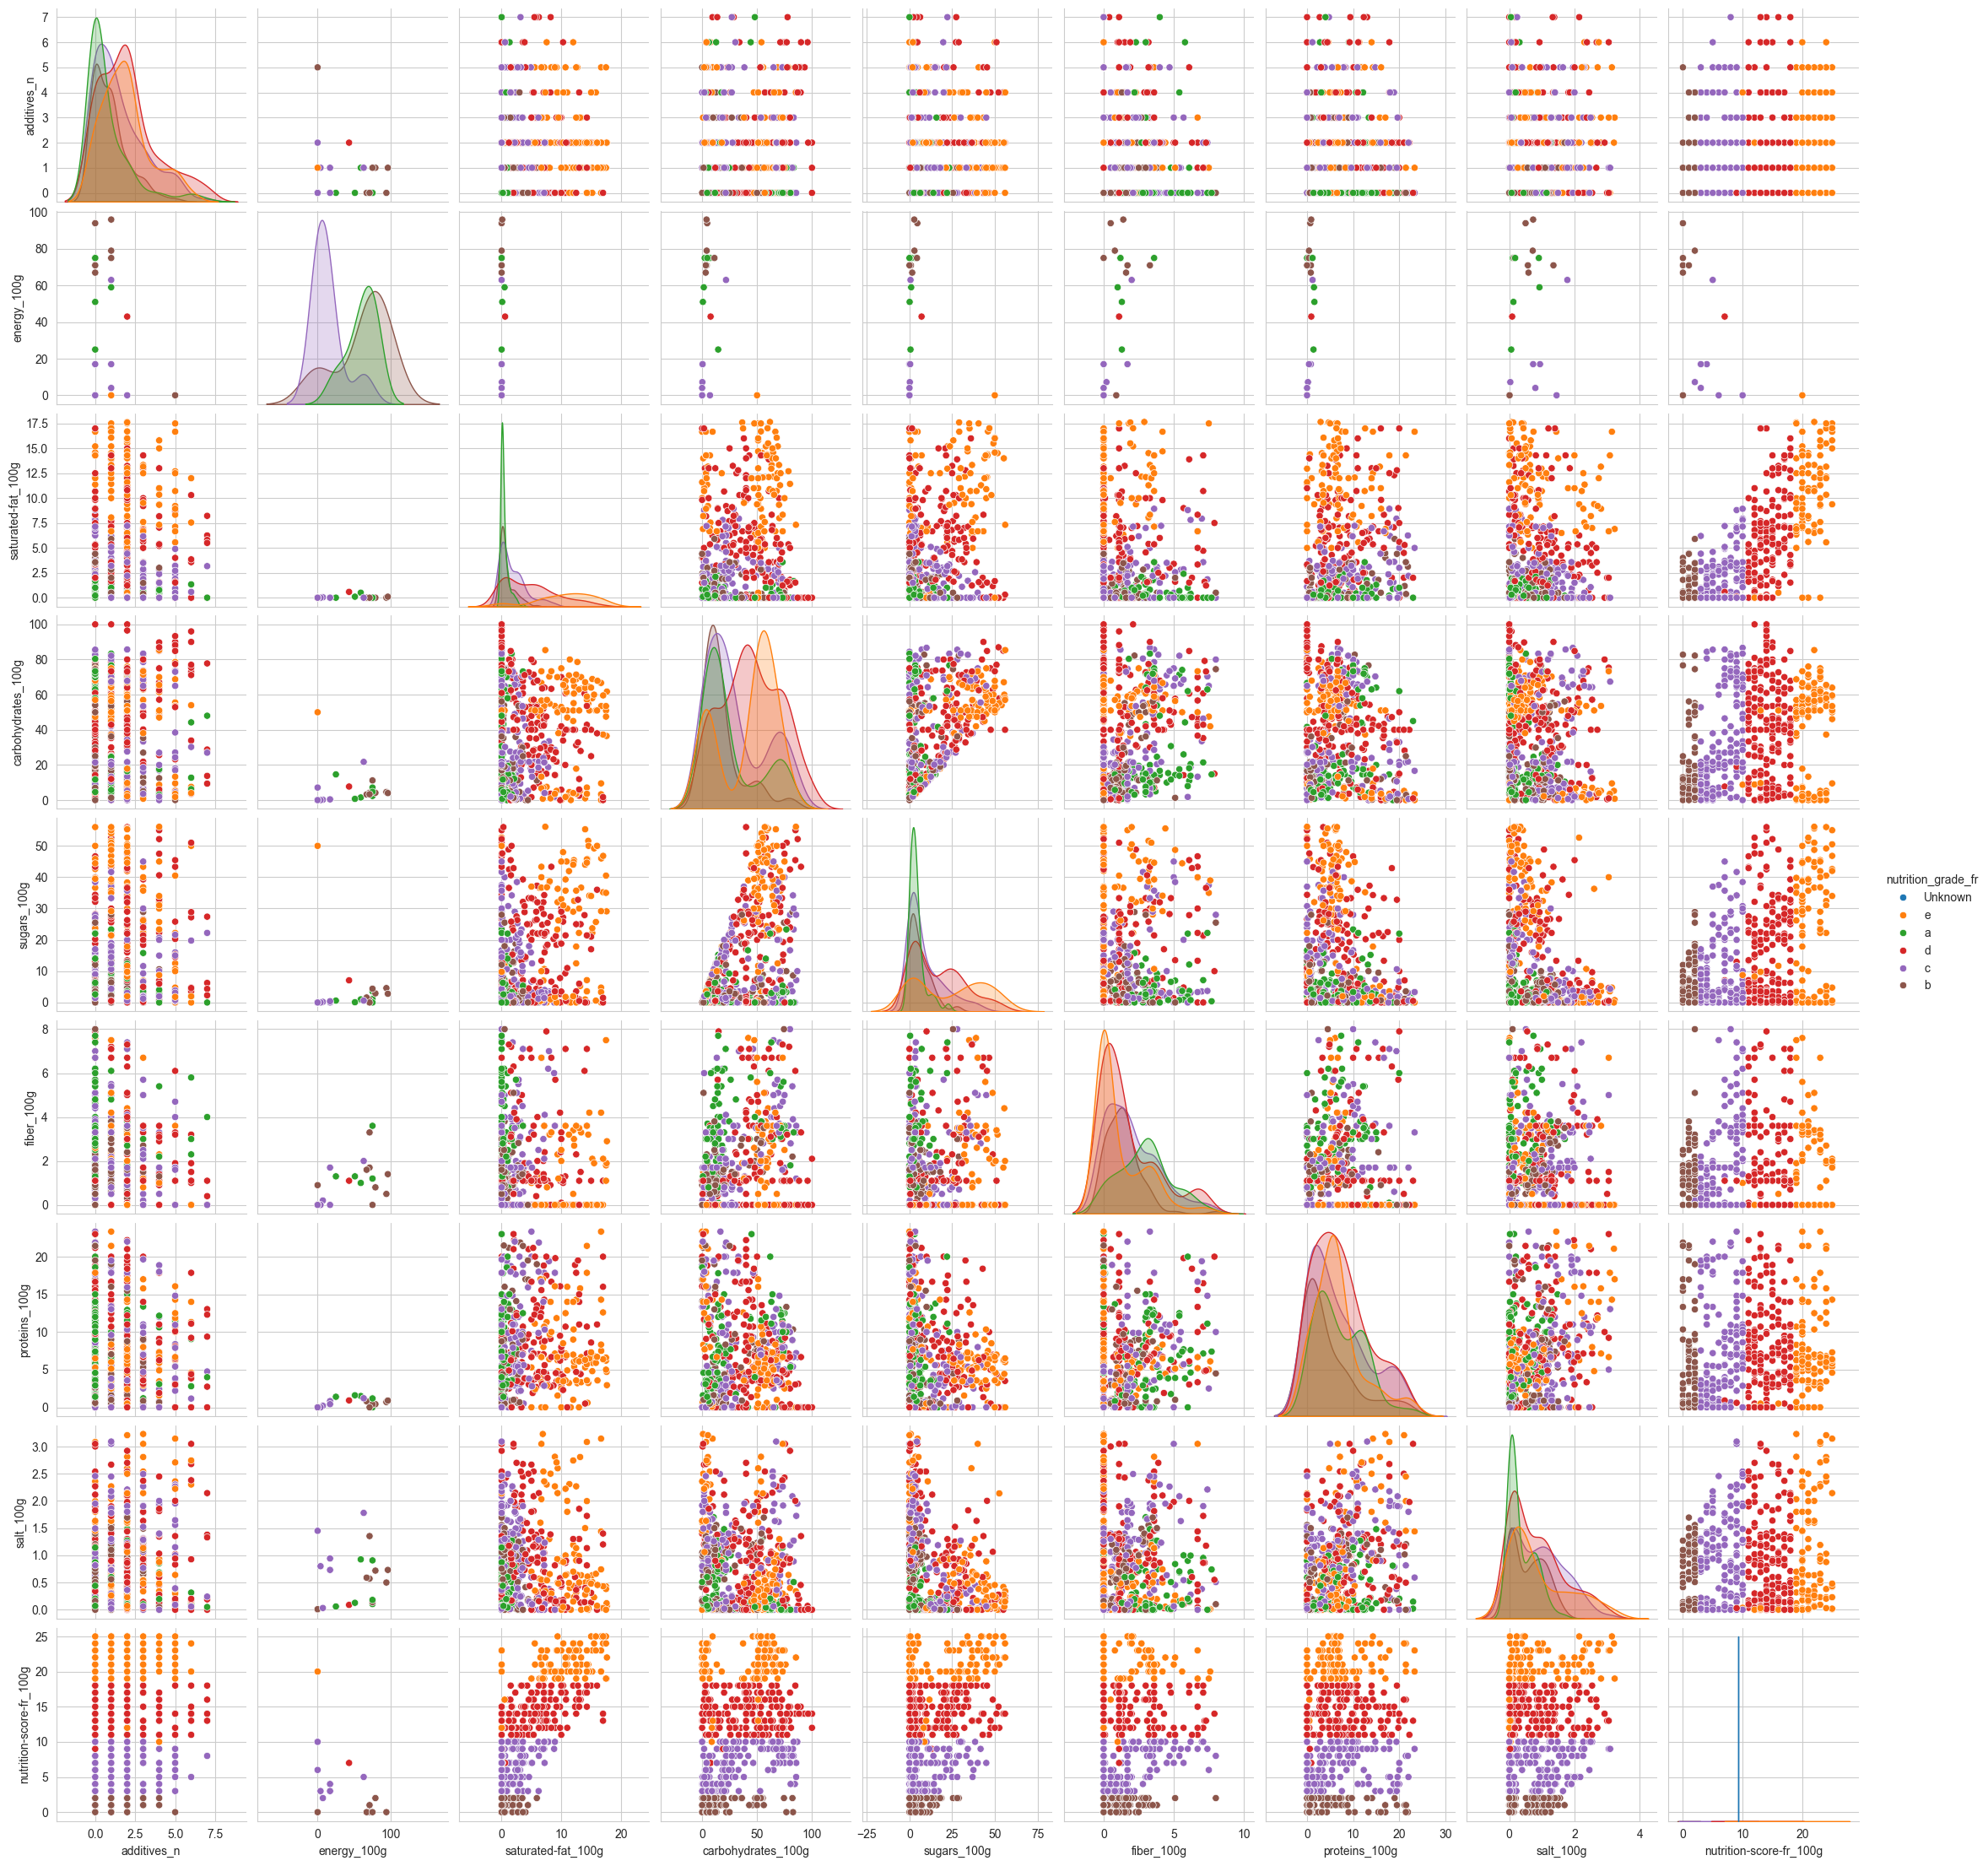

In [264]:
# Analyse bi-varié multiple grace a la scatter plot matrix
sns.pairplot(df.sample(1000), hue='nutrition_grade_fr')

## <a id='toc1_4_'></a>[Analyse en composante principale (PCA)](#toc0_)

In [265]:
pca_cols = [
            'energy_100g',
            'saturated-fat_100g', 
            'carbohydrates_100g', 
            'sugars_100g', 
            'fiber_100g',
            'proteins_100g', 
            'salt_100g',
            ]


### <a id='toc1_4_1_'></a>[Scree plot](#toc0_)

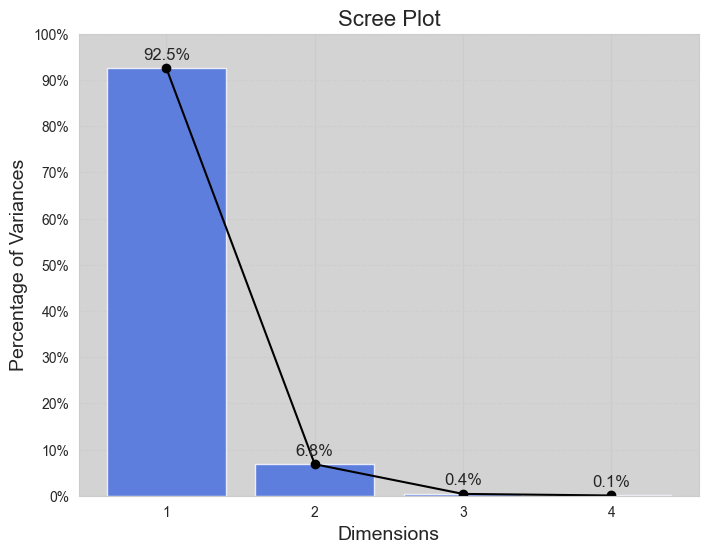

In [ ]:
# Standardize the data
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[pca_cols].dropna())

# Fit PCA
pca = PCA()
pca.fit(df_scaled)


# Example data
# Fake values for the moment i need to replace it with real data
explained_variance = [0.925, 0.0682, 0.0039, 0.0005]  
dimensions = range(1, len(explained_variance) + 1)

plt.figure(figsize=(8, 6))
plt.bar(dimensions, explained_variance, color='royalblue', alpha=0.8)
plt.plot(dimensions, explained_variance, marker='o', color='black')

# Adding percentage labels on the bars
for i, v in enumerate(explained_variance):
    plt.text(i + 1, v + 0.02, f"{v*100:.1f}%", ha='center', fontsize=12)

plt.title('Scree Plot', fontsize=16)
plt.xlabel('Dimensions', fontsize=14)
plt.ylabel('Percentage of Variances', fontsize=14)

plt.xticks(dimensions)
plt.yticks(np.arange(0, 1.1, 0.1), [f"{int(y * 100)}%" for y in np.arange(0, 1.1, 0.1)])  # Percentage y-axis
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.gca().set_facecolor('lightgrey')  # Change background color
plt.show()


### <a id='toc1_4_2_'></a>[Cercle des correlation](#toc0_)

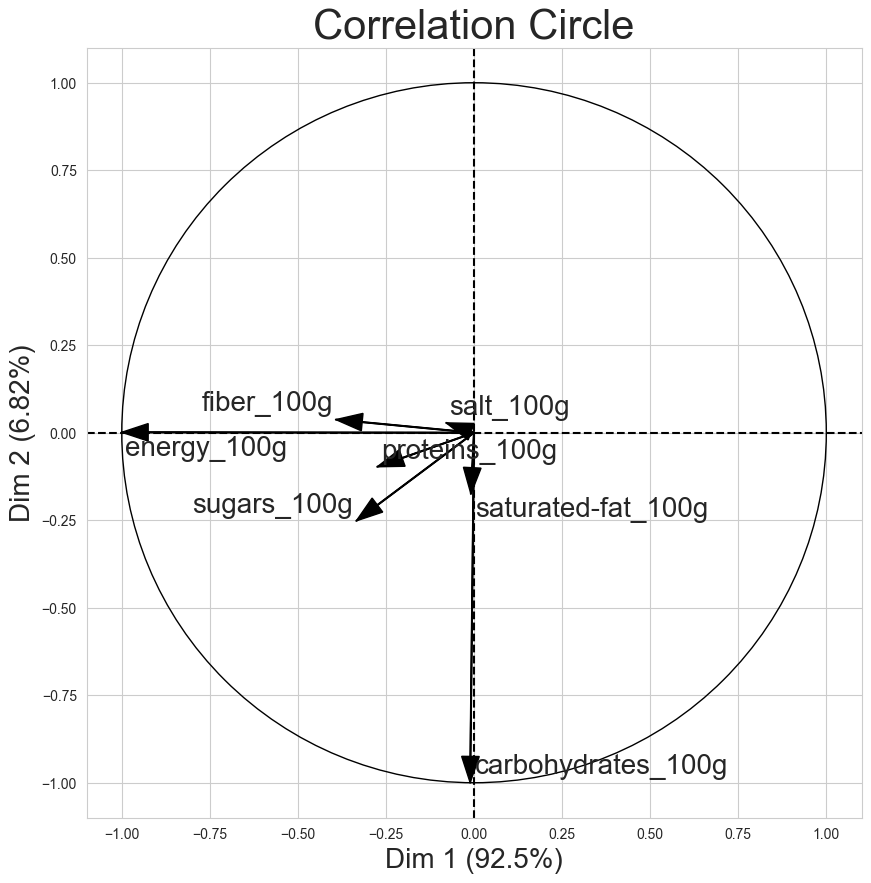

In [267]:
# Cercle de corr
generate_graph(data=df, graph_type='pca', cols=pca_cols, dimensions=(1,2))


### <a id='toc1_4_3_'></a>[Interpretation des resultats](#toc0_)

Ce cercle de corrélation met en évidence des relations fortes entre certaines variables nutritionnelles, notamment entre les glucides, les sucres et l'énergie, qui jouent un rôle majeur dans la structuration des données (Dim 1). Il montre également des corrélations moins significatives entre certaines variables, comme les protéines et les graisses, qui ne sont pas des contributeurs majeurs à la variance dans ce jeu de données. Dim 1 capte presque toute la structure, ce qui signifie que ces variables sont principalement expliquées par une seule composante.

## <a id='toc1_5_'></a>[ANOVA](#toc0_)

### <a id='toc1_5_1_'></a>[Calcul de l'anova](#toc0_)

In [268]:
def anova(df, plot, x, y):
    # Recuperations de valeurs numeriques
    numerical_columns = list(df.select_dtypes(include="number").columns)

    # Résultats ANOVA pour chaque colonne numérique
    anova_results = {}
    for col in numerical_columns:
        # Séparer les groupes selon la variable catégorielle
        groups = [df[col][df['nutrition_grade_fr'] == cat] for cat in df['nutrition_grade_fr'].unique()]
        # Appliquer l'ANOVA
        f_val, p_val = stats.f_oneway(*groups)
        anova_results[col] = {'F-value': f_val, 'p-value': p_val}

    if plot:
        generate_graph(df, graph_type='anova', x=x, y=y)
        

    # Afficher les résultats
    return anova_results

### <a id='toc1_5_2_'></a>[Plot de l'anova](#toc0_)

C:\Users\223115316\AppData\Local\Temp\ipykernel_28008\637962776.py:137: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


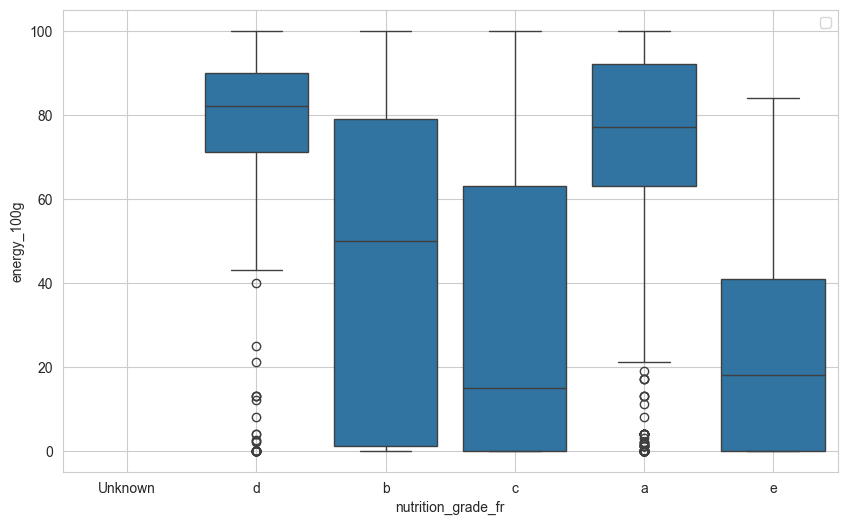

{'additives_n': {'F-value': nan, 'p-value': nan}, 'energy_100g': {'F-value': nan, 'p-value': nan}, 'saturated-fat_100g': {'F-value': nan, 'p-value': nan}, 'carbohydrates_100g': {'F-value': nan, 'p-value': nan}, 'sugars_100g': {'F-value': nan, 'p-value': nan}, 'fiber_100g': {'F-value': nan, 'p-value': nan}, 'proteins_100g': {'F-value': nan, 'p-value': nan}, 'salt_100g': {'F-value': nan, 'p-value': nan}, 'nutrition-score-fr_100g': {'F-value': nan, 'p-value': nan}}


In [269]:
resultat_anova = anova(df, True, 'nutrition_grade_fr', 'energy_100g')
print(resultat_anova)

### <a id='toc1_5_3_'></a>[Interpretation des resultats](#toc0_)

Si on recapitule le json on obtient 

| Variable                             | F-value           | p-value |
|--------------------------------------|-------------------|---------|
| additives_n                          | 2344.95           | 0.0     |
| ingredients_from_palm_oil_n         | 791.87            | 0.0     |
| ingredients_that_may_be_from_palm_oil_n | 306.51        | 0.0     |
| energy_kj                            | 28023.35          | 0.0     |
| fat_100g                             | 18397.22          | 0.0     |
| saturated-fat_100g                  | 34942.42          | 0.0     |
| carbohydrates_100g                  | 4874.44           | 0.0     |
| sugars_100g                         | 11301.89          | 0.0     |
| fiber_100g                          | 3294.61           | 0.0     |
| proteins_100g                       | 2891.05           | 0.0     |
| salt_100g                           | 1011.53           | 0.0     |
| sodium_100g                         | 1011.53           | 0.0     |
| nutrition-score-fr_100g            | 335269.58         | 0.0     |
| nutrition-score-uk_100g            | 244228.88         | 0.0     |

L'analyse de variance (ANOVA) réalisée sur les différentes variables numériques en fonction de la variable catégorielle révèle des résultats significatifs dans tous les cas examinés. Les valeurs F élevées, allant de 306.51 à 335269.58, indiquent que la variance entre les groupes est bien supérieure à la variance au sein des groupes, suggérant des différences marquées dans les moyennes des groupes pour chacune des variables.

De plus, les p-values égales à 0.0 pour toutes les variables analysées indiquent que les différences observées sont statistiquement significatives. Cela signifie que la variable catégorielle a un impact important sur chaque mesure numérique, justifiant ainsi l'importance de la prise en compte de cette variable lors de l'analyse des données.

Les variables relatives aux nutriments tels que nutrition-score-fr_100g et nutrition-score-uk_100g affichent les valeurs F les plus élevées, ce qui pourrait suggérer des disparités significatives dans la qualité nutritionnelle des produits étudiés. Les résultats mettent en évidence des différences claires dans les teneurs en additifs, graisses, sucres, et autres composants, ce qui peut avoir des implications importantes pour les décisions réglementaires, les recommandations de consommation et les stratégies de formulation des produits.

Dans l'ensemble, cette analyse souligne l'importance d'explorer les effets des facteurs catégoriels sur les caractéristiques numériques dans des études de nutrition et de santé publique.

# Reponse à la Problématique

| Avantages de l'auto-complétion dans Open Food Facts |
|-----------------------------------------------------|
| Gain de temps et d'efficacité                        |
| Précision et cohérence des données                   |
| Amélioration de la qualité des données               |
| Facilitation de l'exploration des données            |
| Personnalisation et adaptation aux besoins spécifiques |

## <a id='toc1_6_'></a>[Respect des RGPD](#toc0_)

| Critères                          | Justifications                                                                                                                                                     |
|-----------------------------------|-------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **Nature des Données Traitées**   | Le dataset utilisé (openfoodfacts_dataset.csv) contient des informations sur des produits alimentaires (valeurs nutritionnelles, marques, pays, etc.) qui sont généralement anonymisées. |
| **Absence de Données Personnelles**| Les données manipulées ne contiennent pas d'informations personnelles (noms, adresses, numéros de téléphone, identifiants uniques) permettant d'identifier une personne physique.       |
| **Finalité du Traitement**        | L'objectif principal est de nettoyer et préparer des données pour des analyses statistiques et des problématiques métier liées à la santé publique, orienté vers l'amélioration des données au niveau agrégé. |
| **Conformité aux Principes du RGPD** | Bien que le RGPD ne soit pas directement applicable, des bonnes pratiques de gestion des données (minimisation des données, sécurisation des informations) sont respectées.                  |
| **Absence de Consentement et de Base Légale** | Les notions de consentement et de base légale ne s'appliquent pas, car les données ne concernent pas des personnes physiques.                                            |
